# DNN演習課題
### 17FI008 飯村海斗


In [63]:
# coding: utf-8
import os
import sys
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *

from tensorflow import keras
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd

## 音声データの読み込み

### master_csvの定義

In [64]:
# csvファイルから読み込み
filenames_csv = "./metadata/filelist.csv".replace('/', os.sep)
audios = "./audio_const_16000/".replace('/', os.sep)
master_csv = pd.read_csv(filenames_csv)
master_csv

,filename,target,phoneme
0,rec01-000.wav,0,a
1,rec01-001.wav,1,i
2,rec01-002.wav,2,u
3,rec01-003.wav,3,e
4,rec01-004.wav,4,o
...,...,...,...
245,rec11-020.wav,4,o
246,rec11-021.wav,0,a
247,rec11-022.wav,1,i
248,rec11-023.wav,2,u


### class_pdの定義

In [65]:
# arrange target label and its name
class_dict = {}
for i in range(master_csv.shape[0]):
    if master_csv.loc[i,"target"] not in class_dict.keys():
        class_dict[master_csv.loc[i,"target"]] = master_csv.loc[i,"phoneme"]

class_pd = pd.DataFrame(list(class_dict.items()), columns=["labels","classes"])
class_pd

,labels,classes
0,0,a
1,1,i
2,2,u
3,3,e
4,4,o


## 機械学習の下準備

### 関数定義

##### wavデータの読み込み

In [66]:
def load_wave_data(audio_dir, file_name):
    '''

    Parameters
    ----------
    audio_dir
    file_name

    Returns
    -------
    np.ndarray [shape=(n,) or (2, n)]

    '''
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

#### change wave data to mel-stft

In [67]:
def calculate_melsp(x, n_fft=1024, hop_length=128):
    '''

    Parameters
    ----------
    x
    n_fft
    hop_length

    Returns
    -------
    np.ndarray

    '''
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

#### display wave in plots

In [68]:
def show_wave(x):
    '''

    To display wav graph in matplotlib.pyplot

    Parameters

    ----------
    x

    Returns
    -------
    void

    '''
    plt.plot(x)
    plt.show()

#### display wave in heatmap

In [69]:
def show_melsp(melsp, fs):
    '''

    Display wave in matplotlib.pylot at as heatmap

    Parameters
    ----------
    melsp
    fs

    Returns
    -------
    void

    '''
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

#### data augmentation: shift sound in timeframe

In [97]:
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

#### data augmentation: stretch sound

In [71]:
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

#### whitenoise

In [72]:
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

### 関数の使い方

wave size:(6615,)
melsp size:(128, 52)
samping rate:44100


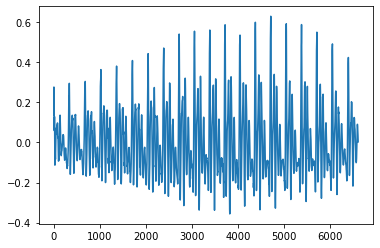

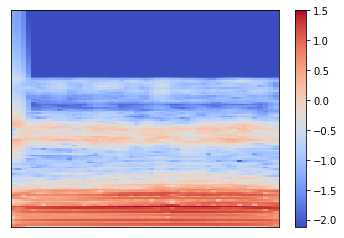

In [73]:
# normal
x, fs = load_wave_data(audios, master_csv.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)
ipd.Audio(x, rate=fs)


wave size:(6615,)
melsp size:(128, 52)
samping rate:44100


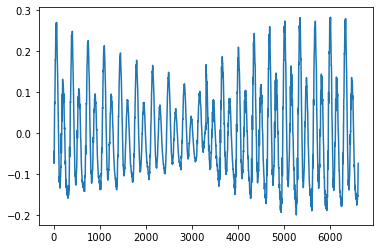

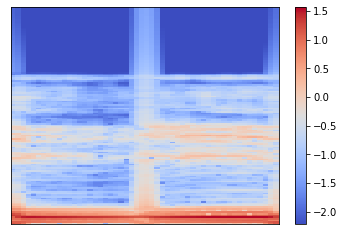

In [74]:
# shift_sound
x, fs = load_wave_data(audios, master_csv.loc[1,"filename"])
x_ss = shift_sound(x)
melsp = calculate_melsp(x_ss)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_ss.shape, melsp.shape, fs))
show_wave(x_ss)
show_melsp(melsp, fs)
ipd.Audio(x, rate=fs)

wave size:(6615,)
melsp size:(128, 52)
samping rate:44100


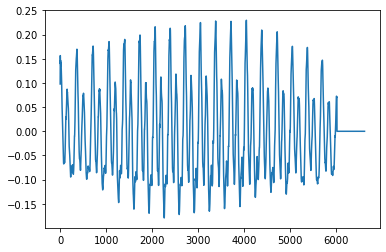

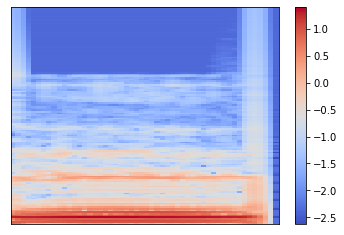

In [75]:
# stretch_sound
x, fs = load_wave_data(audios, master_csv.loc[2,"filename"])
x_st = stretch_sound(x)
melsp = calculate_melsp(x_st)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_st.shape, melsp.shape, fs))
show_wave(x_st)
show_melsp(melsp, fs)
ipd.Audio(x, rate=fs)

In [76]:
# get training dataset and target dataset
x = list(master_csv.loc[:,"filename"])
y = list(master_csv.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train),
                                                                len(x_test),
                                                                len(y_test)))

x train:187
y train:187
x test:63
y test:63


#### 各カテゴリ毎のカウント数を表示

In [77]:
a = np.zeros(5)
for c in y_test:
    a[c] += 1
print(a)

[13. 13. 12. 12. 13.]


#### 音声ファイルのプロパティを手動設定

In [78]:
# 周波数を128に
# 時間を52に設定
freq = 128
time = 52

### save wave data in npz, with augmentation

In [79]:
# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(audios, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

### 機械学習用にnpzファイルを生成

In [80]:
# save test dataset
if not os.path.exists("esc_melsp_test.npz"):
    save_np_data("esc_melsp_test.npz", x_test,  y_test)

# save raw training dataset
if not os.path.exists("esc_melsp_train_raw.npz"):
    save_np_data("esc_melsp_train_raw.npz", x_train,  y_train)

# save training dataset with white noise
if not os.path.exists("esc_melsp_train_wn.npz"):
    rates = np.random.randint(1,5,len(x_train))/10000
    save_np_data("esc_melsp_train_wn.npz", x_train,  y_train, aug=add_white_noise, rates=rates)

# save training dataset with sound shift
if not os.path.exists("esc_melsp_train_ss.npz"):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data("esc_melsp_train_ss.npz", x_train,  y_train, aug=shift_sound, rates=rates)

# save training dataset with stretch
if not os.path.exists("esc_melsp_train_st.npz"):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data("esc_melsp_train_st.npz", x_train,  y_train, aug=stretch_sound, rates=rates)

if not os.path.exists("esc_melsp_train_com.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(audios, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,5)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez("esc_melsp_train_com.npz", x=np_data, y=np_targets)

#### npzファイルを用いて学習

In [81]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

### dataset files

In [82]:
train_files = ["esc_melsp_train_raw.npz",
               "esc_melsp_train_ss.npz",
               "esc_melsp_train_st.npz",
               "esc_melsp_train_wn.npz",
               "esc_melsp_train_com.npz"]
test_file = "esc_melsp_test.npz"

#### 各定数の設定

In [83]:
train_num = 187
test_num = 63

### define dataset placeholders

In [84]:
x_train = np.zeros(freq*time*train_num*len(train_files)).reshape(train_num*len(train_files), freq, time)
y_train = np.zeros(train_num*len(train_files))

# load dataset

In [85]:
for i in range(len(train_files)):
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]

# load test dataset

In [86]:
test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

# one-hot表現に変更

In [87]:
classes = 5
y_train
y_train = keras.utils.to_categorical(y_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)

# y_train
# y_test

# reshape training dataset

In [88]:
x_train = x_train.reshape(train_num*5, freq, time, 1)
x_test = x_test.reshape(test_num, freq, time, 1)

In [89]:
classes = 5
y_test = keras.utils.to_categorical(y_test, classes)
x_test = x_test.reshape(test_num, freq, time, 1)

In [90]:
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape,
                                                                y_train.shape,
                                                                x_test.shape,
                                                                y_test.shape))

x train:(935, 128, 52, 1)
y train:(935, 5)
x test:(63, 128, 52, 1)
y test:(63, 5, 5)


# chap6

In [91]:
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []

#### 訓練の開始

In [92]:
print(x_train.shape)
x_train

(935, 128, 52, 1)


array([[[[ 0.97164726],
         [ 0.89645737],
         [ 0.68102229],
         ...,
         [ 0.37927946],
         [ 0.66861761],
         [ 0.82998174]],

        [[ 1.07986903],
         [ 1.0776701 ],
         [ 1.04325128],
         ...,
         [ 1.1212604 ],
         [ 1.17427897],
         [ 1.22428262]],

        [[ 0.59248424],
         [ 0.81076568],
         [ 0.93055987],
         ...,
         [ 1.07272947],
         [ 0.98556513],
         [ 1.1240294 ]],

        ...,

        [[-1.49595082],
         [-1.55983853],
         [-1.77561295],
         ...,
         [-2.04705   ],
         [-1.85365009],
         [-1.69400561]],

        [[-1.4988451 ],
         [-1.56270754],
         [-1.77839649],
         ...,
         [-2.04624176],
         [-1.85651708],
         [-1.69693577]],

        [[-1.5002346 ],
         [-1.56406403],
         [-1.77964187],
         ...,
         [-2.04518557],
         [-1.85779488],
         [-1.69829595]]],


       [[[ 0.93077242],


In [93]:
print(y_train.shape)
y_train

(935, 5)


array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [94]:
print(x_test.shape)
x_test

(63, 128, 52, 1)


array([[[[ 0.64539754],
         [ 0.58222425],
         [ 0.28112748],
         ...,
         [ 0.23583168],
         [ 0.39670971],
         [ 0.39936498]],

        [[ 0.68083698],
         [ 0.82309145],
         [ 0.93258244],
         ...,
         [ 0.9008075 ],
         [ 0.9141959 ],
         [ 0.97522414]],

        [[ 1.04084694],
         [ 1.07137764],
         [ 1.10324585],
         ...,
         [ 1.14071679],
         [ 1.13568306],
         [ 1.13390207]],

        ...,

        [[-1.53010774],
         [-1.59399509],
         [-1.80976951],
         ...,
         [-2.1475656 ],
         [-1.77343726],
         [-1.6137929 ]],

        [[-1.53302014],
         [-1.5968827 ],
         [-1.812572  ],
         ...,
         [-2.15035868],
         [-1.77637768],
         [-1.61679626]],

        [[-1.53440356],
         [-1.59823298],
         [-1.81381094],
         ...,
         [-2.15149546],
         [-1.77770758],
         [-1.61820865]]],


       [[[ 0.87156236],


In [95]:
print(y_test.shape)
y_test

(63, 5, 5)


array([[[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       ...,

       [[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]], dtype=float32)

In [96]:
train_size = x_train.shape[0]
batch_size = 16
max_iterations = 1000

for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = x_test[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

IndexError: index 470 is out of bounds for axis 0 with size 63

#### グラフの描画

In [ ]:
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()